In [1]:
!pip install matplotlib
#mc cp s3/tordjx ummt --recursive
# watch -n 0.5 nvidia-smi


In [1]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head =4 
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 1024
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 512

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"]).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"]).to(device)

#IF WE WANT TO LOAD PREVIOUSLY TRAINED MODEL
model_en.load_state_dict(torch.load("tordjx/model_en"))
model_fr.load_state_dict(torch.load("tordjx/model_fr"))

<All keys matched successfully>

In [2]:
# val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
# train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
train_features = torch.from_numpy(train_features)
val_features = torch.from_numpy(val_features)

In [4]:
train_data_fr = [tokenized_fr, train_features]
train_data_en = [tokenized_en, train_features]
mixed_train(model_fr,model_en,train_data_fr,train_data_en,500,batch_size, True,[1/2,1])


/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Iteration : 0 batch numéro : 181 en 31 ms par itération, moyenne loss 1.8099217406623271 current lr [5.449673790581555e-07] [9.04508497187466e-06]
Iteration : 0 batch numéro : 362 en 29 ms par itération, moyenne loss 1.2719218526755907 current lr [9.455032620942343e-06] [2.4471741852422084e-07]
Iteration : 0 batch numéro : 543 en 31 ms par itération, moyenne loss 1.1314021367065155 current lr [6.545084971875198e-06] [8.535533905933294e-06]
Iteration : 0 batch numéro : 724 en 31 ms par itération, moyenne loss 0.9974763613214809 current lr [5.449673790581572e-07] [2.4471741852421957e-07]


KeyboardInterrupt: 

0.0


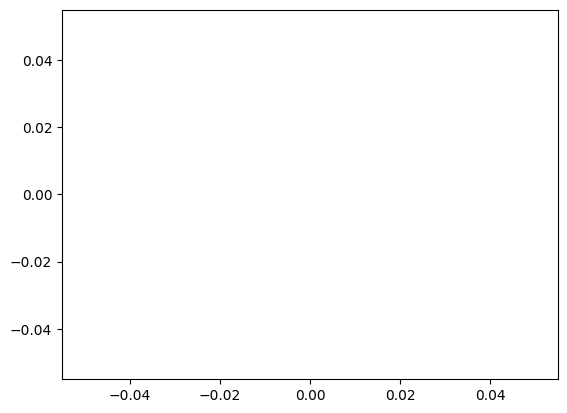

In [3]:
def moving_average(a, n=1000,tail = 0) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return (ret[n - 1:] / n)[tail:]

plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
# plt.plot(model_en.loss_list)
print(len(model_fr.loss_list)/(29000/batch_size))


In [ ]:
torch.save(model_fr.state_dict(), "tordjx/model_fr")
torch.save(model_en.state_dict(), "tordjx/model_en")
import os
import s3fs
!pip install pandas
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
fs.upload("tordjx/model_fr","tordjx/model_fr")
fs.upload("tordjx/model_en","tordjx/model_en")

In [4]:



def greedy_decode(model_A,model_B,text_input, image_input = None, image_bool = False) : 
    EOS_IDX= model_B.end_id
    start_symbol= model_B.begin_id
    max_len = 97
    src_mask = model_A.generate_square_subsequent_mask(model_A.n_head*text_input.shape[0],text_input.shape[1]) # square mask 
    tgt_mask = model_A.generate_square_subsequent_mask(model_A.n_head*text_input.shape[0],text_input.shape[1])
    src_padding_mask  = (text_input== model_A.padding_id).to(device=device)
    tgt_padding_mask = (text_input==  model_A.padding_id).to(device=device)
    memory_mask = model_A.generate_square_subsequent_mask(text_input.shape[0],text_input.shape[1])
    memory_key_padding_mask = (text_input ==  model_A.padding_id).to(device=device)
    if image_bool:
        mem_ei_mask = torch.zeros([text_input.shape[0], text_input.shape[1], text_input.shape[1] + image_input.shape[1]]).to(device=device,dtype = bool)
        mem_ei_mask[:,0:text_input.shape[1], 0:text_input.shape[1]] = model_A.generate_square_subsequent_mask(text_input.shape[0],text_input.shape[1]).to(device=device)
        mem_ei_key_padding_mask = (text_input ==  model_A.padding_id).to(device=device)
        mem_ei_key_padding_mask = torch.cat((mem_ei_key_padding_mask, torch.full([text_input.shape[0], image_input.shape[1]], False).to(device=device)), dim=1)
    memory = model_A.encoder(model_A.positional_encoder(model_A.embedding(text_input)),src_mask,src_padding_mask)
    
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long)
    if image_bool : 
        mem_masks = [memory_mask, mem_ei_mask]
        mem_padding_masks = [memory_key_padding_mask, mem_ei_key_padding_mask]
        image_encoded = model_A.feedforward(image_input)
    for i in range(max_len-1):
        if image_bool:
            x = [model_A.positional_encoder(model_A.embedding(ys), image_encoded]
            out = model_B.decoder(x,memory, tgt_mask , mem_masks , tgt_padding_mask, mem_padding_masks)

        else:
            x = model_A.positional_encoder(model_A.embedding(ys)
            out = model_B.decoder(x,memory, tgt_mask , [memory_mask] , tgt_padding_mask, [memory_key_padding_mask])
    
        # out = out.transpose(0, 1) est ce utile ?
        prob = model_B.output_layer(out)
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys
    



In [3]:
#%%
train_data_fr = [tokenized_fr, train_features]
train_data_en = [tokenized_en, train_features]
def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" or word == "TOKEN_VIDE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        
        else :
            sentence+=word +" "
    return sentence

def traduit(model_A,model_B,data, inv_map,image_bool):
    model_en.eval()
    model_fr.eval()
    if image_bool : 
        data,features= data
    output = torch.argmax(cycle_consistent_forward(model_A,model_B,data,features, True),dim = 2)[j]
    return tensor_to_sentence(output.view(-1),inv_map)



def donne_random():
    i = np.random.randint(len(tokenized_en)//batch_size)
    j = np.random.randint(batch_size)
    batched_data=batchify(train_data_en,batch_size,True)
    data,features = batched_data
    return data[i],features[i]

text,features = donne_random()
features = features.to(device,dtype=torch.float32)
data = [text,features]
for i in range(10):
    j = np.random.randint(batch_size)
    print("Phrase à traduire : \n" + tensor_to_sentence(text[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model_en,model_fr,data, inv_map_fr,True))


#%%

/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Phrase à traduire : 
children are listening to a man in a blue shirt . 
 Phrase traduite : 
 font font font font font ensemble ement font ensemble ensemble font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font 
Phrase à traduire : 
a child playing with some yarn . 
 Phrase traduite : 
 font font deux font ement font ensemble font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font font fo